# Image Segmentation using Keras

In this tutorial you will see how to setup a simple model for image segmentation using the popular
[PASCAL VOC dataset](http://host.robots.ox.ac.uk/pascal/VOC/)
([mirror](https://pjreddie.com/projects/pascal-voc-dataset-mirror/)). For each pixel in the image we will try to predict if the pixel is foreground or background.

First off, let's import everything we'll need for the tutorial

In [1]:
from pathlib import Path
from tqdm import tqdm
import keras
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


More tutorials at https://github.com/fchollet/keras-resources

# Data Wrangling

Keras has a prefered way of storing image datasets. PASCAL VOC comes with a different layout so we first have to rearrange some things.

We create two folders, one for the training and one for validation, using the split given in PASCAL VOC. In each folder we create one folder for the images and one for the the annotation masks. Then we need one more dummy folder to make the keras data loader happy.

In [2]:
# Download the dataset. If you already have it downloaded somewhere read the next cell.
voc_tarfile = keras.utils.get_file(
    fname='VOCtrainval_11-May-2012.tar',
    origin='http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar',
    extract=True,
    file_hash='e14f763270cf193d0b5f74b169f44157a4b0c6efa708f4dd0ff78ee691763bcb')
voc = Path(voc_tarfile).parent / 'VOCdevkit' / 'VOC2012'

In [3]:
# If you've downloaded the dataset to somewhere else uncomment the line below and fill in the path
#voc = Path('<path to VOC2012 folder>')

In [4]:
# Read the image ids for the training and test sets
trainset = [id_.strip() for id_ in open(voc / 'ImageSets' / 'Segmentation' / 'train.txt')]
valset = [id_.strip() for id_ in open(voc / 'ImageSets' / 'Segmentation' / 'val.txt')]
print(f'Found {len(trainset)} images for training and {len(valset)} for validation.')

Found 1464 images for training and 1449 for validation.


In [6]:
def create_image_folders(image_ids, root_path):
    """Create folders for images and masks and copy files in.
    
    image_ids: list of image ids to copy into the folders.
    root_path: path where to place the new folders.
    """
    image_dir = Path(root_path) / 'image' / 'dummy'
    mask_dir = Path(root_path) / 'mask' / 'dummy'

    os.makedirs(image_dir)
    os.makedirs(mask_dir)

    for image in tqdm(image_ids, desc='linking images'):
        # Symlink the images instead of copying them to avoid some duplication.
        image_src = voc / 'JPEGImages' / f'{image}.jpg'
        image_dst = image_dir / f'{image}.jpg'
        os.symlink(image_src, image_dst)

        mask_src = voc / 'SegmentationClass' / f'{image}.png'
        mask_dst = mask_dir / f'{image}.png'
        os.symlink(mask_src, mask_dst)

# Create folders for both the training and validation set.
create_image_folders(trainset, 'data/train')
create_image_folders(valset, 'data/val')

linking images: 100%|██████████| 1449/1449 [00:00<00:00, 5711.87it/s]


# Loading Data

Keras comes with some utilities for loading images.
Since images can be large, we want to avoid loading the all into memory at the same time 
(not really a problem with a dataset of 3000 images, but nice to see how to do it).
We can use the [`ImageDataGenerator`](https://keras.io/preprocessing/image/#imagedatagenerator-class)
class which can load a folder of images batch by batch so we don't need to keep it all in memory.

Lets load a batch of images and look at them with `matplotlib`.

Found 1464 images belonging to 1 classes.


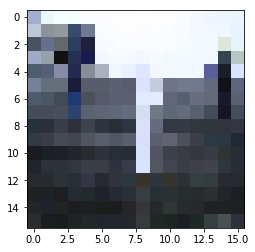

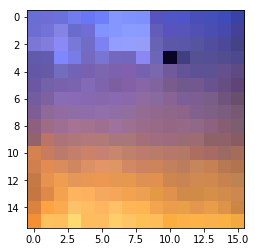

In [8]:
# The size to rescale the images to. Smaller values should speed up learning, larger values should lead to a better model.
SIZE = 16

# Rescale the pixel from the range [0, 255] to [0, 1] to help visualization and training the network.
imdatagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
im_batch = imdatagen.flow_from_directory('data/train/image',
                                         target_size=(SIZE, SIZE),
                                         batch_size=2,
                                         class_mode=None)[0]
plt.imshow(im_batch[0, ...])
plt.show()
plt.imshow(im_batch[1, ...])
plt.show()

Note how every time the previous cell is run the first batch of two examples is different. This will cause problems if we want to load the masks with a second `ImageDataGenerator` and have the images and the masks line up. We could disable shuffling, but that's a Bad Idea&trade; when training deep learning models using Stochastic Gradient Descent. Instead we fix the `seed` of each generator.

In [21]:
class ZipSequence(keras.utils.Sequence):
    """Helper that zips two sequences.
    
    Mostly so that keras doesn't complain.
    """

    def __init__(self, a, b):
        super().__init__()

        if len(a) != len(b):
            raise ValueError('length of both sequences must be equal: '
                             '{} vs. {}'.format(len(a), len(b)))
        self.a = a
        self.b = b

    def __len__(self):
        return len(self.a)

    def __getitem__(self, idx):
        return self.a[idx], self.b[idx]


def categories_to_foreground_mask(categories):
    """TODO Convert PASCAL VOC categories to foreground/background masks."""
    foreground = categories.sum(axis=-1) != 0.0
    return foreground.reshape(foreground.shape + (1,)).astype('float32')
    return categories / 255  # Just scale to [0, 1] for now.


def image_mask_sequence(folder, batch_size, shuffle=True, size=SIZE, seed=4):
    """Return a sequence on (image, mask) pairs."""

    folder = Path(folder)  # Ensure that folder is a pathlib.Path
    imgen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
    images = imgen.flow_from_directory(folder / 'image',
                                       target_size=(size, size),
                                       batch_size=batch_size,
                                       shuffle=shuffle,
                                       seed=seed,
                                       class_mode=None)

    maskgen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=categories_to_foreground_mask)
    masks = maskgen.flow_from_directory(folder / 'mask',
                                        color_mode='grayscale',  # Uncomment once categories_to_foreground_mask is filled in.
                                        target_size=(size, size),
                                        batch_size=batch_size,
                                        shuffle=shuffle,
                                        seed=seed,
                                        class_mode=None)
    return ZipSequence(images, masks)

Let's load one batch to see what it looks like.

Found 1464 images belonging to 1 classes.
Found 1464 images belonging to 1 classes.


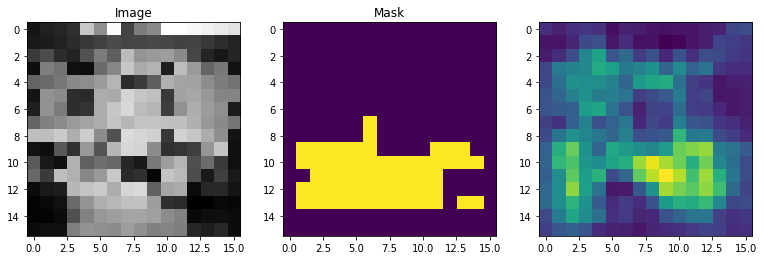

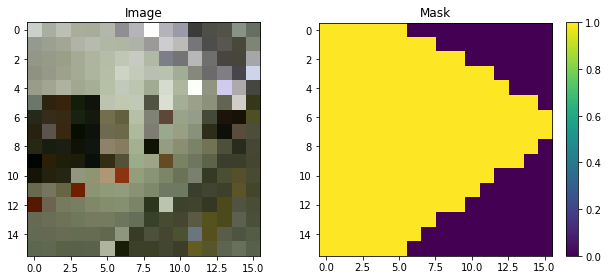

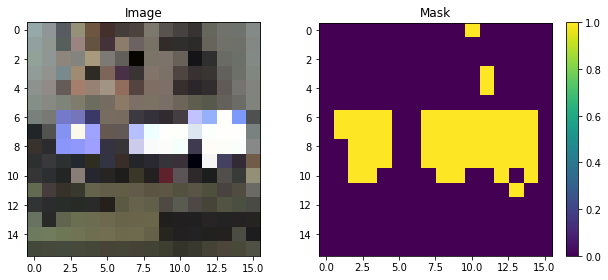

In [50]:
def show_image_mask_pred(image, mask, pred=None):
    """Show an image, a mask, and optionally a prediction side-by-side."""

    width = 9 if pred is None else 15
    ncols = 2 if pred is None else 3
    f, axs = plt.subplots(ncols=ncols, figsize=(width, 4))
    axs[0].imshow(image)
    axs[0].set_title('Image')
    im = axs[1].imshow(mask)
    axs[1].set_title('Mask')
    
    if pred is not None:
        im = axs[2].imshow(pred)
        axs[2].set_title('Prediction')

    if len(mask.shape) == 2 or pred:
        f.colorbar(im)

    plt.tight_layout()
    plt.show(f)

images, masks = image_mask_sequence('data/train', batch_size=2, seed=42)[0]
show_image_mask_pred(images[0, ...], masks[0, ..., 0])
show_image_mask_pred(images[1, ...], masks[1, ..., 0])

You'll notice that masks have difference colours for different classes of objects. The PASCAL VOC has 20 different object categories that model must learn to predict, but we will only try foreground and background.
Try to update `categories_to_foreground_mask()` above to convert these category masks to masks where 0.0 represents background and 1.0 foreground.

# Define Model

Now that we can load data, we will define a super simple U-Net. The model should roughly look like:

```
   Image
     |
     v
   Conv2d ----> Downsample
     |              |
     |              v
     |            Conv2d
     |              |
     v              v
Concatenate <--- Upsample
     |
     v
   Conv2d
     |
     v
 Prediction

```

(This doesn't look like much of a U because my ASCII art skills could be better, just squint and pretend 😀)

Since the U-Net is not strictly sequential we will make use of the Keras [functional API].
Usually with functional API you create a layer and immediately call:

```python
x = Conv2D(16, (3, 3))(x)
```

Since we control the arguments passed to the layers we can connect layer output however we want, and also concatenate them using [`Concatenate()`][https://keras.io/layers/merge/#concatenate]. So lets go ahead and define our simple U-Net.

[functional API]: https://keras.io/getting-started/functional-api-guide/

In [11]:
# Shortcuts to the layer we need to make it more readable.
Activation = keras.layers.Activation
AveragePooling2D = keras.layers.AveragePooling2D
BatchNormalization = keras.layers.BatchNormalization
Conv2D = keras.layers.Conv2D
Input = keras.layers.Input
UpSampling2D = keras.layers.UpSampling2D

In [12]:
# In general it's good to name your operations because then Keras
# can use better names when it creates Tensorflow objects.

# All functional API
image = Input(shape=[SIZE, SIZE, 3], name='image')

# A common building block in Conv Nets is this Conv3x3-BatchNorm-Relu combination.
# The `same` padding is different from the U-Net paper and will lead to edge effects.
x = Conv2D(filters=16, kernel_size=(3, 3), padding='same')(image)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Save the large scale output to concatenate with later.
x_large = x
x_small = AveragePooling2D(pool_size=(2, 2))(x)

x = Conv2D(32, (3, 3), padding='same')(x_small)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x_upsampled = UpSampling2D(size=(2, 2))(x)
x = keras.layers.concatenate([x_large, x_upsampled])

x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Logits is a common name to give to the pre-sigmoid or softmax values.
# The convention comes statistics and logistic regression I believe.
logits = Conv2D(1, (1, 1), padding='same', name='logit')(x)

# The sigmoid will ensure all our prediction as in the range [0, 1].
# It also suggests a probabilistic interpretation of our output but we skip this for now.
prediction = Activation('sigmoid', name='prediction')(logits)

# In the functional API everything is tied together with a Model() instance.
model = keras.models.Model(inputs=image, outputs=prediction)

# If we wanted to have multiple output, e.g. for auxillary losses or related predictions,
# or multiple inputs, maybe some metadata of the image, we would pass a list to Model()

One advantage of Keras is it comes with some tools to summarize and visualize the structure of models.

In [13]:
# A list of all the layers and how they're connected.
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              (None, 16, 16, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 16)   448         image[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 16, 16, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
average_po

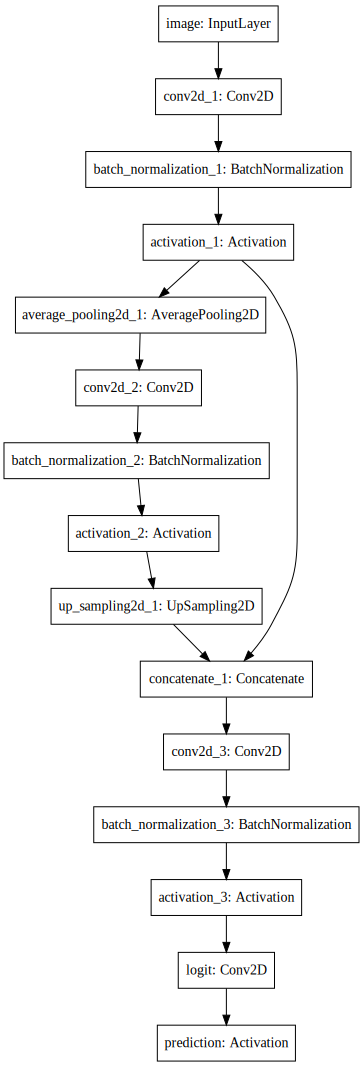

In [14]:
# This visualization might not work depending on how graphviz is installed, but it gives a simple overview of the structure.
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

# Compile Model

From: https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

Now that the model is defined, we can compile it.

Compiling the model uses the efficient numerical libraries under the covers (the so-called backend) such as Theano or TensorFlow. The backend automatically chooses the best way to represent the network for training and making predictions to run on your hardware, such as CPU or GPU or even distributed.

When compiling, we must specify some additional properties required when training the network. Remember training a network means finding the best set of weights to make predictions for this problem.

We must specify the loss function to use to evaluate a set of weights, the optimizer used to search through different weights for the network and any optional metrics we would like to collect and report during training.

In this case, we will use logarithmic loss, which for a binary classification problem is defined in Keras as “binary_crossentropy“. We will also use the efficient gradient descent algorithm “adam” for no other reason that it is an efficient default. Learn more about the Adam optimization algorithm in the paper “Adam: A Method for Stochastic Optimization“.

Finally, because it is a classification problem, we will collect and report the classification accuracy as the metric.

In [15]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit Model

From: https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

We have defined our model and compiled it ready for efficient computation.

Now it is time to execute the model on some data.

We can train or fit our model on our data by calling the `fit_generator()` function on the model.

The training process will run for a fixed number of iterations through the dataset called epochs, that we must specify using the `epochs` argument. We can also set the number of instances that are evaluated before a weight update in the network is performed, called the batch size and set using the `batch_size` argument.

For this problem, we will run for a two epochs to begin with and a relatively small batch size of 10 to check everything works. If you don't have a GPU this still might take a couple of minutes. Optimal values can be chosen later by experiementation.

In [22]:
train_seq = image_mask_sequence('data/train', batch_size=10, size=16)

Found 1464 images belonging to 1 classes.
Found 1464 images belonging to 1 classes.


In [23]:
h = model.fit_generator(train_seq, epochs=2)

Epoch 1/2
147/147 [==============================] - 21s 145ms/step - loss: 0.5826 - acc: 0.6899
Epoch 2/2
147/147 [==============================] - 19s 126ms/step - loss: 0.5146 - acc: 0.7417


This is where the work happens on your CPU or GPU. If you have a GPU try to increase the number of epochs until the loss and acc stop improving.

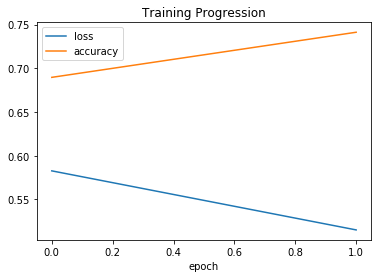

In [36]:
# Plot the training progress.

plt.title('Training Progression')
plt.plot(h.epoch, h.history['loss'], label='loss')
plt.plot(h.epoch, h.history['acc'], label='accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Evaluate Model

From: https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

We have trained our neural network on half the dataset and we can evaluate the performance of the network on the other half.
This will only give us an idea of how well our model performs with new data.

You can evaluate your model using the `evaluate_generator()` function on your model.
This will generate a prediction for each input and output pair and collect scores, including the average loss and any metrics you have configured, such as accuracy.

In [37]:
val_seq = image_mask_sequence('data/val', batch_size=10, shuffle=False)

Found 1449 images belonging to 1 classes.
Found 1449 images belonging to 1 classes.


In [39]:
scores = model.evaluate_generator(train_seq)

In [40]:
print(f'{model.metrics_names[1]} {scores[1]*100:.2f}%')

acc 73.70%


We can also make a prediction to visually see how the model is performing.
In general, it can be very useful to see that your model produces and not just relying on the metrics.
Machine learning models will often train and improve even if there are major bugs in the code.

In [41]:
predictions = model.predict_generator(val_seq, steps=1)

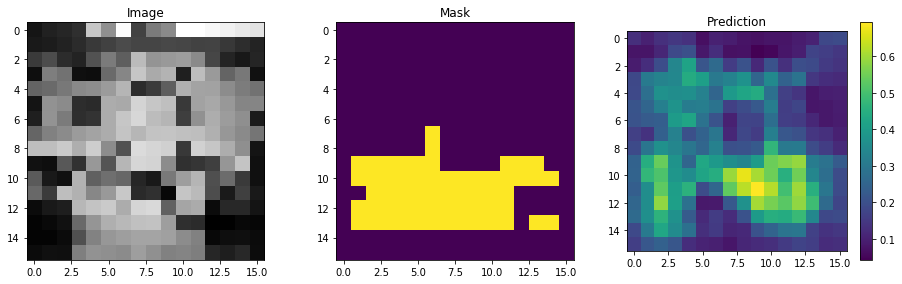

In [51]:
images, mask = val_seq[0]
show_image_mask_pred(images[0, ...], mask[0, ..., 0], predictions[0, ..., 0])

## Extension Options

* More epochs
* Better network
* Different optimizer
* Try data augmentation (maybe the augmentation from the U-Net paper)
* Try it on different data

# Solutions

In [ ]:
def categories_to_foreground_mask(categories):
    foreground = categories.sum(axis=-1) != 0.0
    return foreground.reshape(foreground.shape + (1,)).astype('float32')